<a href="https://colab.research.google.com/github/mikaelagarciaa/tcc-segmentacao-de-colaboradores-por-kmeans/blob/main/TCC_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Desenvolvimento do projeto para TCC - MBA em Data Science and Anaytics
Segmentação Estratégica de Talentos: Uma Aplicação de K-means na Gestão de Desempenho Orientada a Dados


1. IMPORTAÇÃO DAS BIBLIOTECAS

In [37]:
!pip install -U kaleido
!pip install -U plotly
!plotly_get_chrome
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import scipy.stats as stats
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: None
Do you want to proceed? [y/n] y
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


2. CARREGAMENTO E INSPEÇÃO INICIAL DOS DADOS

Leitura do dataset "IBM HR Analytics Employee Attrition & Performance" em csv

In [32]:
try:
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
except FileNotFoundError:
    print("Erro: Arquivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' não encontrado.")
    print("Por favor, baixe o dataset do Kaggle e coloque-o na mesma pasta do seu script/notebook.")
    # Interrompe a execução se o arquivo não for encontrado.
    exit()

Mostra as primeiras 5 linhas do dataset "IBM HR Analytics Employee Attrition & Performance"

In [33]:
display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Mostra informações gerais: tipos de dados, contagem de colunas e valores não-nulos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Mostra estatísticas descritivas para as colunas numéricas

In [5]:
print(df.describe())

               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335            

3. PRÉ-PROCESSAMENTO INICIAL

Verificação dos valores únicos nas colunas suspeitas

In [6]:
print("Valores únicos em 'EmployeeCount':", df['EmployeeCount'].unique())
print("Valores únicos em 'StandardHours':", df['StandardHours'].unique())
print("Valores únicos em 'Over18':", df['Over18'].unique())

Valores únicos em 'EmployeeCount': [1]
Valores únicos em 'StandardHours': [80]
Valores únicos em 'Over18': ['Y']


Verificação de valores únicos em 'EmployeeNumber'

In [7]:
print("Número de IDs únicos em 'EmployeeNumber':", df['EmployeeNumber'].nunique())
print("Total de funcionários:", len(df))

Número de IDs únicos em 'EmployeeNumber': 1470
Total de funcionários: 1470


Exclusão de colunas que não agregam a análise

In [8]:
colunas_para_remover = ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18']
df_processado = df.drop(columns=colunas_para_remover)

print(f"\nColunas removidas: {colunas_para_remover}")
print(f"Número de colunas após a remoção: {df_processado.shape[1]}")


Colunas removidas: ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18']
Número de colunas após a remoção: 31


4. ANÁLISE EXPLORATÓRIA VISUAL

Análise da Avaliação de Desempenho (PerformanceRating)

Gráfico 'Distribuição da Avaliação de Desempenho' salvo como figura_performance_rating.png


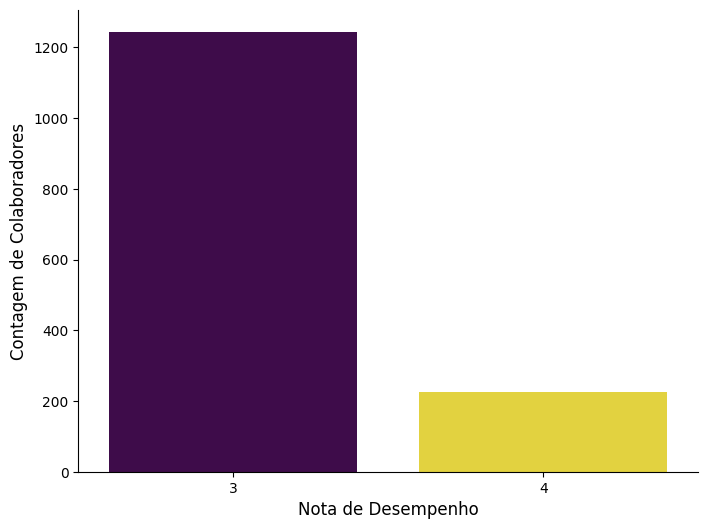

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='PerformanceRating', data=df_processado, palette='viridis', hue='PerformanceRating', legend=False)

# Título, grades e bordas foram removidos para seguir as normas do manual do TCC.
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# -------------------------

plt.xlabel('Nota de Desempenho', fontsize=12)
plt.ylabel('Contagem de Colaboradores', fontsize=12)
plt.savefig('figura_performance_rating.png', dpi=300)

print("Gráfico 'Distribuição da Avaliação de Desempenho' salvo como figura_performance_rating.png")

Análise da Satisfação com o Trabalho (JobSatisfaction)

/tmp/ipython-input-4007715466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='JobSatisfaction', data=df_processado, palette='plasma')


Gráfico 'Distribuição da Satisfação com o Trabalho' salvo como figura_job_satisfaction.png


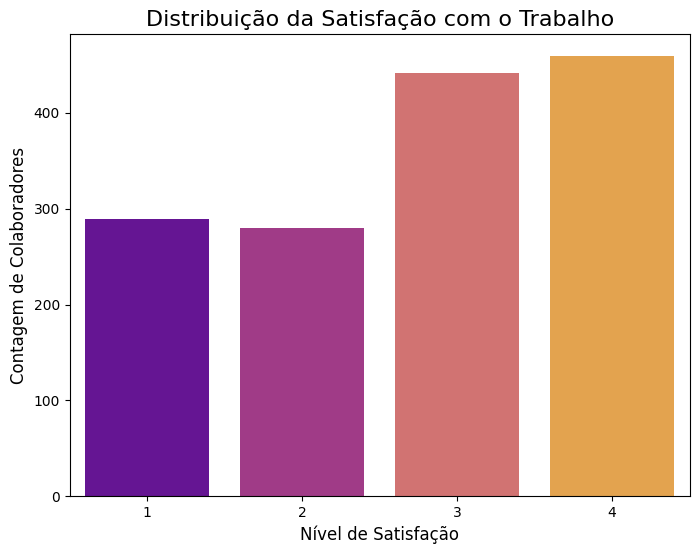

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='JobSatisfaction', data=df_processado, palette='plasma')
plt.title('Distribuição da Satisfação com o Trabalho', fontsize=16)
plt.xlabel('Nível de Satisfação', fontsize=12)
plt.ylabel('Contagem de Colaboradores', fontsize=12)
plt.savefig('figura_job_satisfaction.png', dpi=300)
print("Gráfico 'Distribuição da Satisfação com o Trabalho' salvo como figura_job_satisfaction.png")

Relação entre Avaliação de Desempenho e Nível do Cargo

/tmp/ipython-input-2561011161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PerformanceRating', y='MonthlyIncome', data=df_processado, palette='coolwarm')


Gráfico 'Relação entre Desempenho, Nível do Cargo e Salário' salvo como figura_performance_vs_salario.png


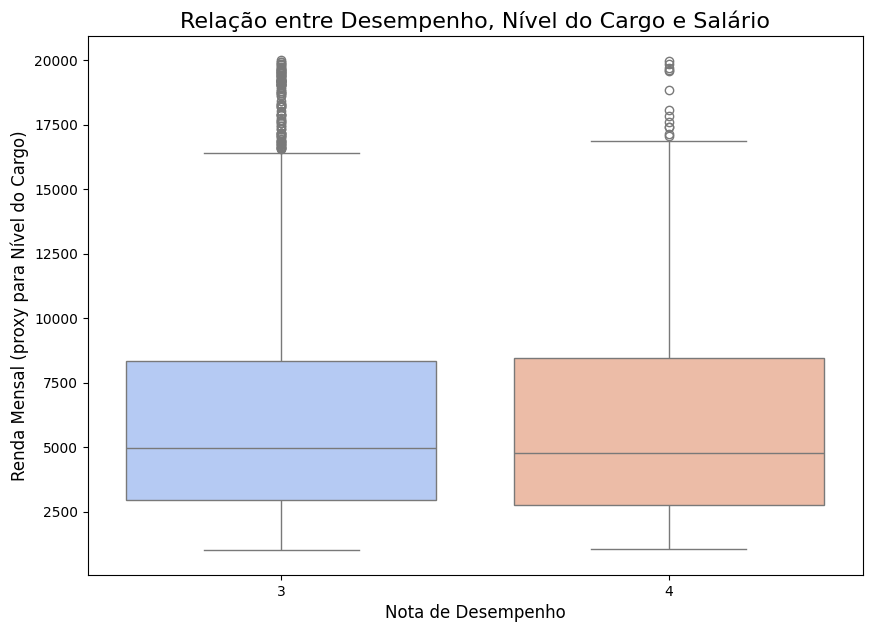

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='PerformanceRating', y='MonthlyIncome', data=df_processado, palette='coolwarm')
plt.title('Relação entre Desempenho, Nível do Cargo e Salário', fontsize=16)
plt.xlabel('Nota de Desempenho', fontsize=12)
plt.ylabel('Renda Mensal (proxy para Nível do Cargo)', fontsize=12)
plt.savefig('figura_performance_vs_salario.png', dpi=300)
print("Gráfico 'Relação entre Desempenho, Nível do Cargo e Salário' salvo como figura_performance_vs_salario.png")

Análise de Correlação entre Variáveis Numéricas

Gráfico 'Mapa de Calor de Correlação' salvo como figura_heatmap_correlacao.png


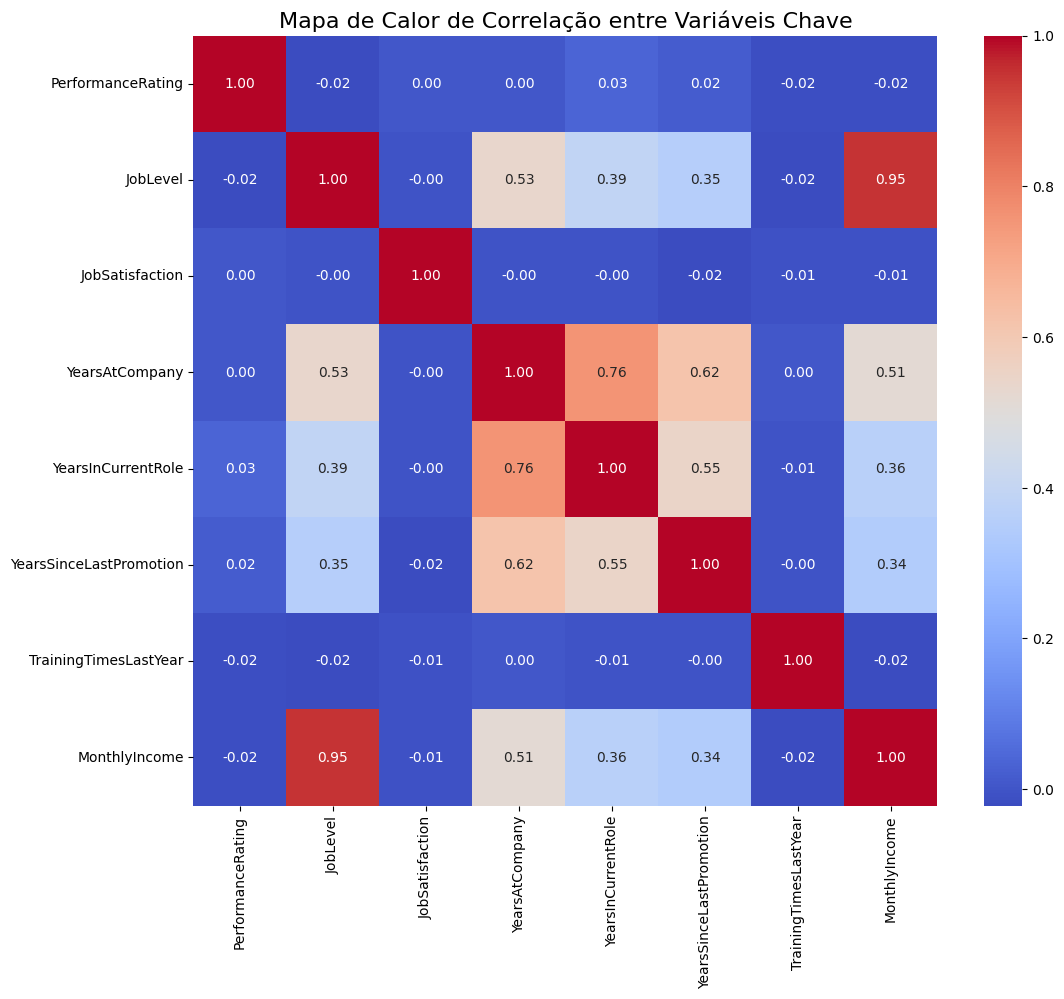

In [12]:
variaveis_modelo = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear'
                   ]

# Adicionando 'MonthlyIncome' para enriquecer a análise de correlação
variaveis_para_correlacao = variaveis_modelo + ['MonthlyIncome']

plt.figure(figsize=(12, 10))
correlation_matrix = df_processado[variaveis_para_correlacao].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlação entre Variáveis Chave', fontsize=16)
plt.savefig('figura_heatmap_correlacao.png', dpi=300)
print("Gráfico 'Mapa de Calor de Correlação' salvo como figura_heatmap_correlacao.png")

5. PREPARAÇÃO FINAL DOS DADOS PARA MODELAGEM

Seleção de Variáveis (Features)

In [13]:
variaveis_numericas = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
    'MonthlyIncome'
]

variaveis_categoricas = [
    'Department', 'EducationField', 'JobRole'
]

In [14]:
df_modelo = df_processado[variaveis_numericas + variaveis_categoricas].copy()
print(f"Variáveis selecionadas para o modelo: {df_modelo.columns.tolist()}")

Variáveis selecionadas para o modelo: ['PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear', 'MonthlyIncome', 'Department', 'EducationField', 'JobRole']


One-Hot Encoding de Variáveis Categóricas

In [15]:
df_modelo = pd.get_dummies(df_modelo, columns=variaveis_categoricas, drop_first=True)
print(f"\nNúmero total de variáveis após One-Hot Encoding: {df_modelo.shape[1]}")


Número total de variáveis após One-Hot Encoding: 23


Padronização (Scaling)

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_modelo)

6. DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS (K)

Método do Cotovelo (Elbow Method)

In [17]:
inercia = []
range_k = range(2, 11) # Teste de 2 a 10 clusters

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

Plotando o gráfico do Método Cotovelo

Gráfico 'Método do Cotovelo' salvo como figura_2_metodo_cotovelo.png


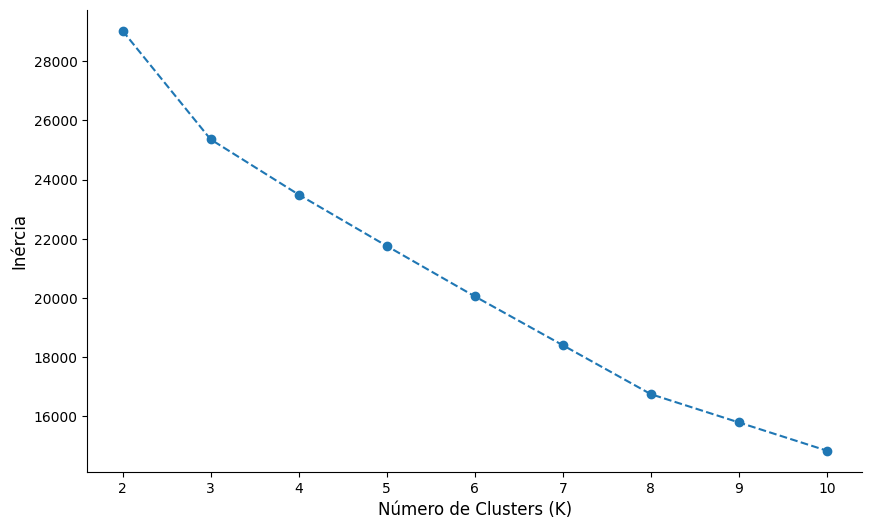

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range_k, inercia, marker='o', linestyle='--')
plt.grid(False) # Remove as linhas de grade
ax = plt.gca()
ax.spines['top'].set_visible(False)   # Remove a borda superior
ax.spines['right'].set_visible(False) # Remove a borda direita
# -------------------------

plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Inércia', fontsize=12)
plt.xticks(range_k)
plt.savefig('figura_2_metodo_cotovelo.png', dpi=300)
print("Gráfico 'Método do Cotovelo' salvo como figura_2_metodo_cotovelo.png")

Coeficiente de Silhueta (Silhouette Score)

In [19]:
silhueta = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhueta.append(score)

Plotando o gráfico de Coeficiente de Silhueta

Gráfico 'Coeficiente de Silhueta' salvo como figura_3_coeficiente_silhueta.png


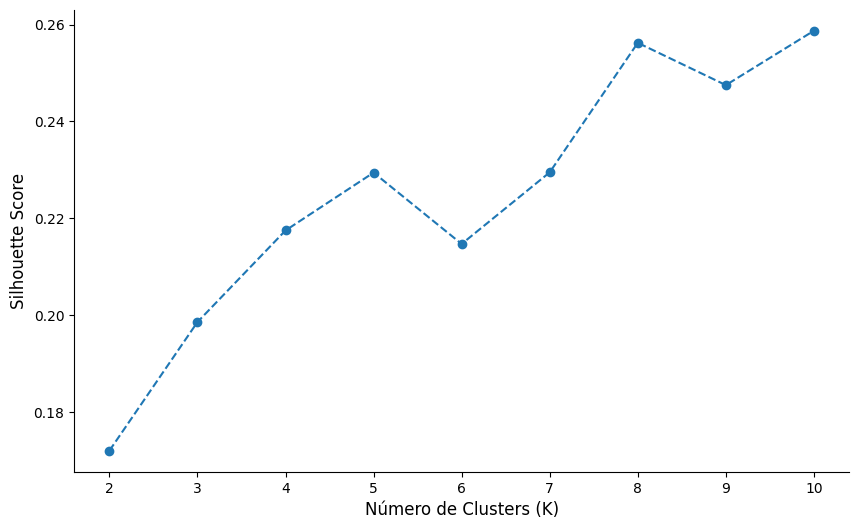

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range_k, silhueta, marker='o', linestyle='--')
plt.grid(False) # Remove as linhas de grade
ax = plt.gca()
ax.spines['top'].set_visible(False)   # Remove a borda superior
ax.spines['right'].set_visible(False) # Remove a borda direita
# -------------------------

plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range_k)
plt.savefig('figura_3_coeficiente_silhueta.png', dpi=300)
print("Gráfico 'Coeficiente de Silhueta' salvo como figura_3_coeficiente_silhueta.png")

Métrica Quantitativa (Calinski-Harabasz Score)

In [21]:
calinski_harabasz = []
range_k = range(2, 11)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    calinski_harabasz.append(score)

Plotando o gráfico de Coeficiente Calinski-Harabasz

Gráfico 'Índice Calinski-Harabasz' salvo como figura_4_calinski_harabasz.png


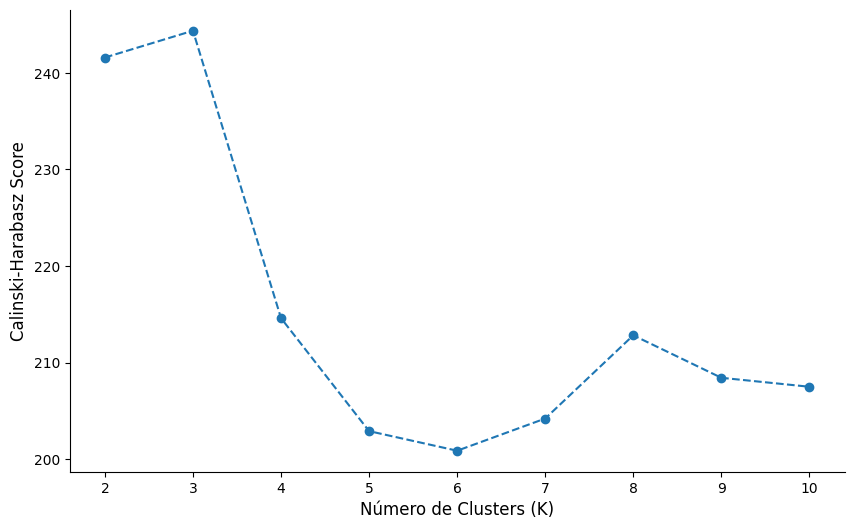

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range_k, calinski_harabasz, marker='o', linestyle='--')
plt.grid(False) # Remove as linhas de grade
ax = plt.gca()
ax.spines['top'].set_visible(False)   # Remove a borda superior
ax.spines['right'].set_visible(False) # Remove a borda direita
# -------------------------

plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Calinski-Harabasz Score', fontsize=12)
plt.xticks(range_k)
plt.savefig('figura_4_calinski_harabasz.png', dpi=300)
print("Gráfico 'Índice Calinski-Harabasz' salvo como figura_4_calinski_harabasz.png")

7. APLICAÇÃO FINAL DO MODELO K-MEANS

Cálculo dos Centroides (Médias por Cluster)

In [23]:
# Passo 1: Definir o K ótimo
K_OTIMO = 4

# Passo 2: Treinar o modelo K-means.
kmeans_final = KMeans(n_clusters=K_OTIMO, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Passo 3: Definir a coluna 'cluster'
# A coluna é criada no DataFrame 'df_processado' com os resultados do modelo.
df_processado['cluster'] = kmeans_final.labels_
print("Coluna 'cluster' definida com sucesso no DataFrame 'df_processado'.")
print("---")


# Passo 4: Análise com o DataFrame atualizado.
df_analise = df_processado.copy()

variaveis_para_analise = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
    'MonthlyIncome'
]

centroides_descritivos = df_analise.groupby('cluster')[variaveis_para_analise].mean()

# Arredondando os valores
centroides_descritivos = centroides_descritivos.round(2)

print("Tabela de Centroides (Perfis Médios):")
print(centroides_descritivos)

Coluna 'cluster' definida com sucesso no DataFrame 'df_processado'.
---
Tabela de Centroides (Perfis Médios):
         PerformanceRating  JobLevel  JobSatisfaction  YearsAtCompany  \
cluster                                                                 
0                     3.16      1.56             2.71            5.52   
1                     3.13      2.33             2.76            7.48   
2                     3.17      4.06             2.75           13.83   
3                     3.14      1.08             2.73            2.92   

         YearsInCurrentRole  YearsSinceLastPromotion  TrainingTimesLastYear  \
cluster                                                                       
0                      3.55                     1.55                   2.76   
1                      4.84                     2.48                   2.83   
2                      6.87                     4.73                   2.83   
3                      2.01                     1.06    

In [38]:
# 1. Criar um dicionário com os resultados
dados_validacao = {
    'Número de Clusters (K)': range_k,
    'Inércia': inercia,
    'Coeficiente de Silhueta': silhueta,
    'Índice Calinski-Harabasz': calinski_harabasz
}

# 2. Criar um DataFrame com o pandas para formatar como tabela
tabela_validacao_exata = pd.DataFrame(dados_validacao)

# 3. Arredondar os valores para 3 casas decimais para clareza
tabela_validacao_exata = tabela_validacao_exata.round(3)

# 4. Exibir a tabela final com os seus dados exatos
print("--- Tabela de Validação de Clusters (com seus dados exatos) ---")
print(tabela_validacao_exata.to_string(index=False))

--- Tabela de Validação de Clusters (com seus dados exatos) ---
 Número de Clusters (K)   Inércia  Coeficiente de Silhueta  Índice Calinski-Harabasz
                      2 29032.060                    0.172                   241.596
                      3 25360.826                    0.199                   244.372
                      4 23492.829                    0.217                   214.604
                      5 21756.734                    0.229                   202.903
                      6 20052.871                    0.215                   200.873
                      7 18400.110                    0.229                   204.208
                      8 16745.882                    0.256                   212.826
                      9 15789.591                    0.248                   208.427
                     10 14834.834                    0.259                   207.498


6. VISUALIZAÇÃO DOS PERFIS

In [24]:
centroides_plot = centroides_descritivos.T


Gráfico comparativo dos perfis salvo como figura_4_comparativo_perfis.png


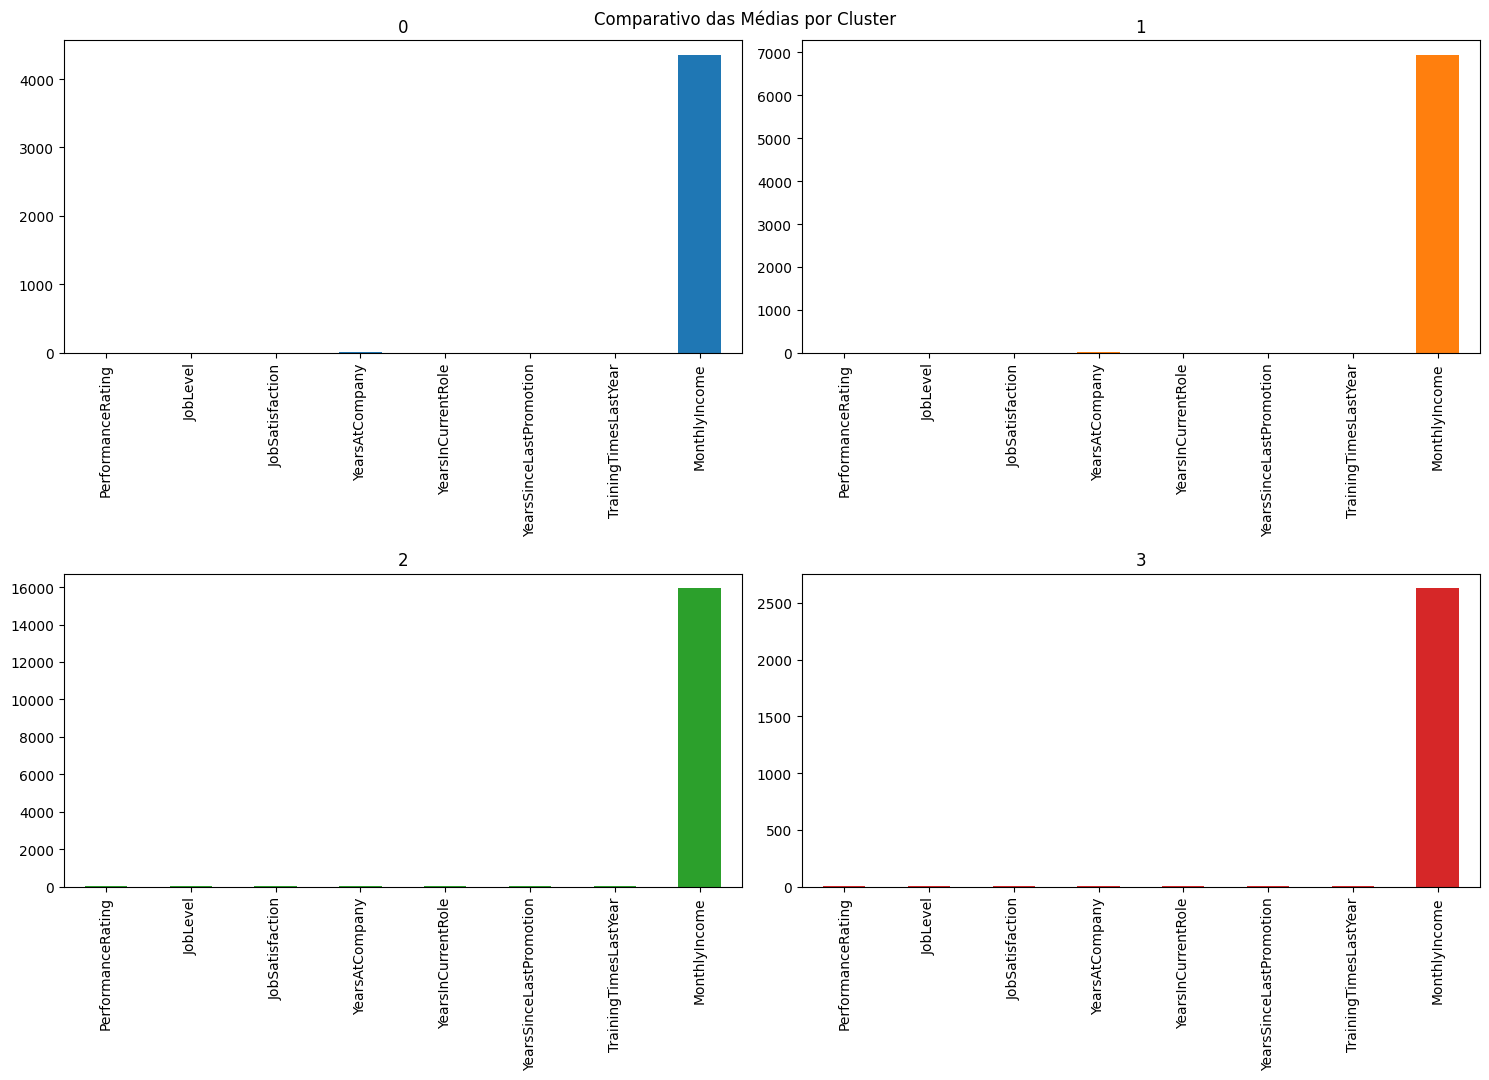

In [25]:
# Criando um gráfico de barras para cada variável
centroides_plot.plot(kind='bar', subplots=True, figsize=(15, 20), layout=(4, 2),
                     legend=False, sharex=False, title='Comparativo das Médias por Cluster')
plt.tight_layout()
plt.savefig('figura_4_comparativo_perfis.png', dpi=300)
print("\nGráfico comparativo dos perfis salvo como figura_4_comparativo_perfis.png")

In [26]:
# Testes para análise qualitativa com K = 3, 4 e 10


print("\n======================================================================")
print("INICIANDO LABORATÓRIO DE COMPARAÇÃO DE CLUSTERS")
print("======================================================================")

# Lista de variáveis que serão analisadas nos perfis
variaveis_para_analise = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
    'MonthlyIncome'
]

# Função para rodar o K-means e analisar os resultados para um 'k' específico.
def analisar_clusters(k, dados_escalados, df_original):
    """
    Roda o K-means para um número 'k' de clusters e imprime a tabela de
    centroides com as médias das características de cada grupo.
    """
    print(f"\n--- ANÁLISE PARA K = {k} ---")

    # Roda o modelo K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalados)

    # Cria uma cópia do dataframe para não alterar o original
    df_temp = df_original.copy()
    df_temp['cluster'] = kmeans.labels_

    # Calcula os centroides (perfis médios)
    centroides = df_temp.groupby('cluster')[variaveis_para_analise].mean().round(2)

    # Imprime a tabela de centroides
    print("Tabela de Centroides (Perfis Médios):")
    print(centroides)
    print("---------------------------------------\n")


# --- Executando a análise para cada K de interesse ---
valores_k_para_testar = [3, 4, 10]

# O loop para chamar a função para cada valor na lista
for k_teste in valores_k_para_testar:
    analisar_clusters(k_teste, X_scaled, df_processado)


INICIANDO LABORATÓRIO DE COMPARAÇÃO DE CLUSTERS

--- ANÁLISE PARA K = 3 ---
Tabela de Centroides (Perfis Médios):
         PerformanceRating  JobLevel  JobSatisfaction  YearsAtCompany  \
cluster                                                                 
0                     3.16      1.56             2.71            5.52   
1                     3.13      2.07             2.76            6.44   
2                     3.17      4.06             2.74           13.98   

         YearsInCurrentRole  YearsSinceLastPromotion  TrainingTimesLastYear  \
cluster                                                                       
0                      3.55                     1.55                   2.76   
1                      4.24                     2.17                   2.88   
2                      6.89                     4.75                   2.81   

         MonthlyIncome  
cluster                 
0              4355.04  
1              6033.73  
2             15908.74 

Gráfico 'Visualização dos Clusters com PCA' salvo como figura_5_visualizacao_pca.png


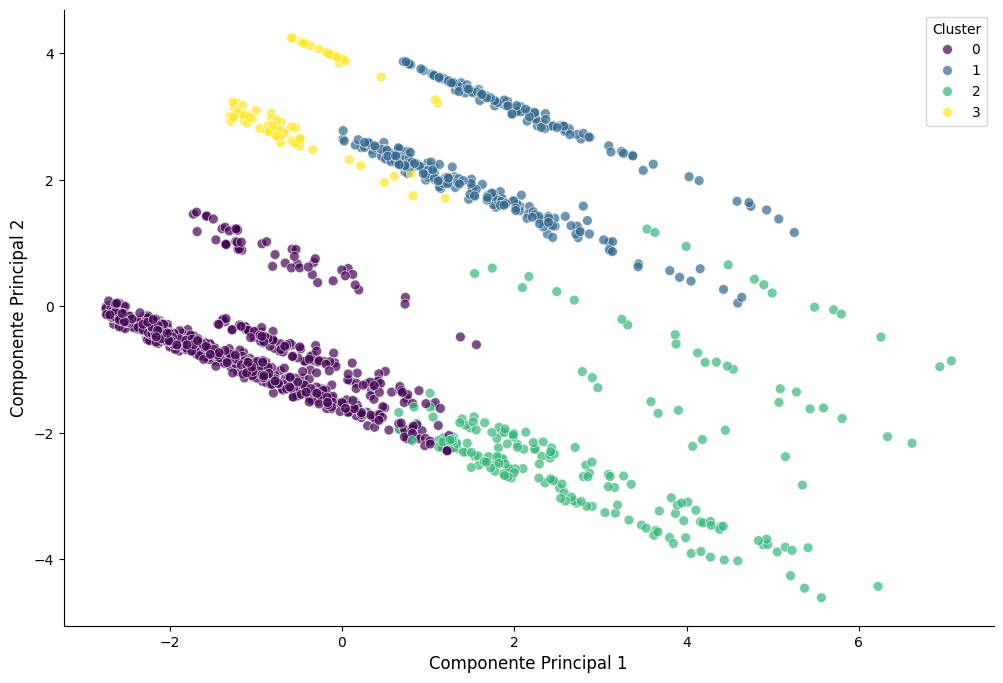

In [27]:
# Visualização dos clustes com PCA (Análise de Componentes Principais)

# 1. Configurar o PCA para reduzir os dados para 2 dimensões.
pca = PCA(n_components=2)

# 2. Aplicar o PCA aos mesmos dados escalados que foram usados no K-means.
X_pca = pca.fit_transform(X_scaled)

# 3. Criar um novo DataFrame com os resultados do PCA para facilitar a plotagem.
df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])

# 4. Adicionar a coluna de 'cluster' que foi gerado com K-means (com K=4).
df_pca['cluster'] = df_processado['cluster']


# 5. Criar o gráfico de dispersão (scatter plot).
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Componente Principal 1',
    y='Componente Principal 2',
    hue='cluster',
    palette='viridis',
    data=df_pca,
    s=50,
    alpha=0.7
)

plt.grid(False) # Remove as linhas de grade
sns.despine()   # Remove as bordas superior e direita (padrão do Seaborn)
# -------------------------

plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.savefig('figura_5_visualizacao_pca.png', dpi=300)
print("Gráfico 'Visualização dos Clusters com PCA' salvo como figura_5_visualizacao_pca.png")

In [28]:
# Visualização avançada: Gráfico de radar para comparação dos perfis

scaled_centroids = kmeans_final.cluster_centers_

# Uso das 8 variáveis numéricas como os eixos no gráfico de radas
radar_variaveis = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
    'MonthlyIncome'
]

nomes_personas = [
    "Profissionais Juniores Sólidos (Cluster 0)",
    "Profissionais Plenos/Sênior Estáveis (Cluster 1)",
    "Líderes e Especialistas Seniores (Cluster 2)",
    "Novos Talentos / Início de Carreira (Cluster 3)"
]

#Criação do Gráfico
fig = go.Figure()

# Adicionando um polígono (traço) para cada cluster
for i in range(K_OTIMO):
    fig.add_trace(go.Scatterpolar(
          r=scaled_centroids[i],         # Valores do centroide para cada variável
          theta=radar_variaveis,         # Nomes das variáveis (eixos do radar)
          fill='toself',                 # Preenche a área do polígono
          name=nomes_personas[i]         # Nome da persona para a legenda
    ))

# Customizando o layout do gráfico
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 2]
    )),
  showlegend=True,
  title="Gráfico de Radar: Comparativo dos Perfis de Colaboradores"
)

# Exibindo o gráfico
fig.show()
fig.write_image("figura_5_grafico_radar.png", scale=2)

8. TESTE ESTATÍSTICO ANOVA

In [31]:
# Lista de variáveis numéricas para teste
variaveis_para_analise = [
    'PerformanceRating', 'JobLevel', 'JobSatisfaction', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
    'MonthlyIncome'
]

# Lista para armazenar os resultados
resultados_anova = []

# Loop para executar a ANOVA para cada variável
for variavel in variaveis_para_analise:

    # 1. Definir o modelo estatístico (variável ~ cluster)
    # C(cluster) trata a coluna 'cluster' como uma variável categórica
    modelo_ols = ols(f'Q("{variavel}") ~ C(cluster)', data=df_processado).fit()

    # 2. Gerar a tabela ANOVA
    tabela_anova = sm.stats.anova_lm(modelo_ols, typ=2)

    # 3. Extrair os valores da tabela
    f_statistic = tabela_anova['F'][0]
    p_value = tabela_anova['PR(>F)'][0]
    df_entre = int(tabela_anova['df'][0])
    df_dentro = int(tabela_anova['df'][1])

    # 4. Calcular o Eta-quadrado (η²) - o tamanho do efeito
    # η² = Soma dos Quadrados (entre grupos) / Soma dos Quadrados (total)
    eta_sq = tabela_anova['sum_sq'][0] / (tabela_anova['sum_sq'][0] + tabela_anova['sum_sq'][1])

    # 5. Armazenar os resultados
    resultados_anova.append({
        'Variável': f'*{variavel}*', # Coloca o nome da variável em itálico
        'Estatística F': f'F({df_entre}, {df_dentro}) = {f_statistic:.2f}',
        'p-valor': '< 0,001' if p_value < 0.001 else f'{p_value:.3f}'.replace('.', ','),
        'η² (Eta-quadrado)': f'{eta_sq:.3f}'.replace('.', ',')
    })

# 6. Criar um DataFrame final com todos os resultados
tabela_final_anova = pd.DataFrame(resultados_anova)

# Exibir a tabela final formatada
print(tabela_final_anova.to_string(index=False))


GERANDO TABELA ANOVA COMPLETA (COM ESTATÍSTICA F e ETA-QUADRADO)
                 Variável        Estatística F p-valor η² (Eta-quadrado)
      *PerformanceRating*    F(3, 1466) = 1.02   0,382             0,002
               *JobLevel*  F(3, 1466) = 890.95 < 0,001             0,646
        *JobSatisfaction*    F(3, 1466) = 0.16   0,924             0,000
         *YearsAtCompany*  F(3, 1466) = 154.07 < 0,001             0,240
     *YearsInCurrentRole*   F(3, 1466) = 69.36 < 0,001             0,124
*YearsSinceLastPromotion*   F(3, 1466) = 67.11 < 0,001             0,121
  *TrainingTimesLastYear*    F(3, 1466) = 1.12   0,339             0,002
          *MonthlyIncome* F(3, 1466) = 1382.82 < 0,001             0,739


/tmp/ipython-input-3318100866.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3318100866.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3318100866.py:33: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-3318100866.py:34: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

9. TESTE POST-HOC

In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Lista APENAS das variáveis que foram significativas na ANOVA ---
# Com base na sua Tabela 2, estas são as variáveis com p-valor < 0.05
variaveis_significativas_anova = [
    'JobLevel',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'MonthlyIncome'
]

# Loop para executar o teste para cada variável significativa
for variavel in variaveis_significativas_anova:

    print(f"\n--- Teste Post-Hoc de Tukey HSD para a variável: '{variavel}' ---")

    # Realiza o teste de Tukey
    tukey_resultado = pairwise_tukeyhsd(endog=df_processado[variavel],
                                        groups=df_processado['cluster'],
                                        alpha=0.05)

    # Imprime a tabela de resultados do teste
    print(tukey_resultado)


--- Teste Post-Hoc de Tukey HSD para a variável: 'JobLevel' ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.7756   0.0  0.6651   0.886   True
     0      2   2.4988   0.0  2.3686  2.6291   True
     0      3  -0.4734   0.0 -0.6685 -0.2784   True
     1      2   1.7233   0.0  1.5737  1.8728   True
     1      3   -1.249   0.0 -1.4575 -1.0405   True
     2      3  -2.9723   0.0 -3.1919 -2.7526   True
---------------------------------------------------

--- Teste Post-Hoc de Tukey HSD para a variável: 'YearsAtCompany' ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   1.9558    0.0   1.0605  2.8511   True
     0      2   8.3137    0.0   7.2576  9.3698   True
     0      3  -2.6056 0.0001  -4.1874 -1.0238   True
     1      2   6.35